## Project Explanation

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

In this project, Building a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. Dataset includes 10,000 tweets that were hand classified.

## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from tqdm import tqdm

from gensim.parsing.preprocessing import remove_stopwords
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import OrderedDict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import classification_report,f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

import torch
import transformers

Using TensorFlow backend.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## Import data

In [3]:
train = pd.read_csv(r'/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv(r'/kaggle/input/nlp-getting-started/test.csv')

In [4]:
print('Number of datapoints in the train dataset : ',train.shape[0])
print('Number of datapoints in the test dataset : ',test.shape[0])

Number of datapoints in the train dataset :  7613
Number of datapoints in the test dataset :  3263


In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [8]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


## Data Preprocess

In [9]:
#removing any shortforms if present
def remove_shortforms(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def remove_special_char(text):
    text = re.sub('[^A-Za-z0-9]+'," ",text)
    return text

def remove_wordswithnum(text):
    text = re.sub("\S*\d\S*", "", text).strip()
    return text

def lowercase(text):
    text = text.lower()
    return text

def remove_stop_words(text):
    text = remove_stopwords(text)
    return text

st = SnowballStemmer(language='english')
def stemming(text):
    r= []
    for word in text :
        a = st.stem(word)
        r.append(a)
    return r

def listToString(s):  
    str1 = " "   
    return (str1.join(s))

def remove_punctuations(text):
    text = re.sub(r'[^\w\s]','',text)
    return text

def remove_links(text):
    text = re.sub(r'http\S+', '', text)
    return text

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    text = lemmatizer.lemmatize(text)
    return text

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [10]:
Y = train['target']
train = train.drop('target',axis=1)
data = pd.concat([train,test],axis=0).reset_index(drop=True)
data.head()

,id,keyword,location,text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...


In [11]:
for i in range(len(data['text'])):
    data['text'][i] = str(data['text'][i])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
data['text'][1]

'Forest fire near La Ronge Sask. Canada'

In [13]:
for i in range(len(data['text'])):
    data['text'][i] = remove_shortforms(data['text'][i])
    data['text'][i] = remove_special_char(data['text'][i])
    data['text'][i] = remove_wordswithnum(data['text'][i])
    data['text'][i] = lowercase(data['text'][i])
    data['text'][i] = remove_stop_words(data['text'][i])
    text = data['text'][i]
    text = text.split()
    data['text'][i] = stemming(text)
    s = data['text'][i]
    data['text'][i] = listToString(s)
    data['text'][i] = lemmatize_words(data['text'][i])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

In [14]:
data['text'][1]

'forest near la rong sask canada'

## Bag of words

In [15]:
cv = CountVectorizer(ngram_range=(1,3))
text_bow = cv.fit_transform(data['text'])
print(text_bow.shape)

(10876, 136413)


In [16]:
train_text = text_bow[:train.shape[0]] 
test_text = text_bow[train.shape[0]:] 

In [17]:
print(train_text.shape)
print(test_text.shape)

(7613, 136413)
(3263, 136413)


### Train Test Split

In [18]:
X_train,X_test,Y_train,Y_test = train_test_split(train_text,Y,test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6090, 136413)
(1523, 136413)
(6090,)
(1523,)


### LR With BoW

In [19]:
lr = LogisticRegression(C=10,penalty='l2')
lr.fit(X_train,Y_train)
pred = lr.predict(X_test)
print("F1 score :",f1_score(Y_test,pred))
print("Classification Report \n\n:",classification_report(Y_test,pred))

F1 score : 0.7442650807136788
Classification Report 

:               precision    recall  f1-score   support

           0       0.78      0.90      0.84       867
           1       0.84      0.67      0.74       656

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### LR with TF IDF

In [20]:
tfidf = TfidfVectorizer(ngram_range=(1,3))
text_tfidf = tfidf.fit_transform(data['text'])
print(text_tfidf.shape)

(10876, 136413)


In [21]:
train_text = text_tfidf[:train.shape[0]] 
test_text = text_tfidf[train.shape[0]:] 
print(train_text.shape)
print(test_text.shape)

(7613, 136413)
(3263, 136413)


In [22]:
X_train,X_test,Y_train,Y_test = train_test_split(train_text,Y,test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6090, 136413)
(1523, 136413)
(6090,)
(1523,)


In [23]:
lr = LogisticRegression(C=100,penalty='l2',max_iter=2000)
lr.fit(X_train,Y_train)
pred = lr.predict(X_test)
print("F1 score :",f1_score(Y_test,pred))
print("Classification Report :",classification_report(Y_test,pred))

F1 score : 0.7062876830318691
Classification Report :               precision    recall  f1-score   support

           0       0.76      0.89      0.82       864
           1       0.82      0.62      0.71       659

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.76      1523
weighted avg       0.78      0.78      0.77      1523



### Word Embedding

In [26]:
import os

print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../input/glove-global-vectors-for-word-representation/glove.6B.200d.txt'), encoding = "utf-8") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split() #split at space
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32') #numpy.asarray()function is used when we want to convert input to an array.
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [27]:
train = pd.read_csv(r'/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv(r'/kaggle/input/nlp-getting-started/test.csv')

In [28]:
Y = train['target']
train = train.drop('target',axis=1)
data = pd.concat([train,test],axis=0).reset_index(drop=True)
text_data = data['text']

In [29]:
text_data

0        Our Deeds are the Reason of this #earthquake M...
1                   Forest fire near La Ronge Sask. Canada
2        All residents asked to 'shelter in place' are ...
3        13,000 people receive #wildfires evacuation or...
4        Just got sent this photo from Ruby #Alaska as ...
                               ...                        
10871    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
10872    Storm in RI worse than last hurricane. My city...
10873    Green Line derailment in Chicago http://t.co/U...
10874    MEG issues Hazardous Weather Outlook (HWO) htt...
10875    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 10876, dtype: object

<p style="color:green">For tokenizing the data i have used the keras.preprocessing fuction called Tokenizer.
    You can search on google for its documentation

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)
sequences = tokenizer.texts_to_sequences(text_data)

In [31]:
word2index = tokenizer.word_index
print("Number of unique tokens : ",len(word2index))

Number of unique tokens :  29319


In [32]:
data_padded = pad_sequences(sequences,100)
print(data_padded.shape)

(10876, 100)


In [33]:
data_padded[6]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  209,   76,
        928,  305, 1120,  898,  318,    8, 1822,    7, 8819, 1121, 2833,
       1701], dtype=int32)

In [34]:
train_pad = data_padded[:train.shape[0]]
test_pad = data_padded[train.shape[0]:]

In [35]:
embedding_matrix = np.zeros((len(word2index)+1,200))

embedding_vec=[]
for word, i in tqdm(word2index.items()):
    embedding_vec = word2vec.get(word)
    if embedding_vec is not None:
        embedding_matrix[i] = embedding_vec

100%|██████████| 29319/29319 [00:00<00:00, 314870.82it/s]


In [36]:
print(embedding_matrix[1])

[ 0.42596    -0.18836001 -0.65114999  0.72987998  0.86216003 -0.019028
  0.036413    0.1523     -0.68856001 -0.15668    -0.95084    -0.31977999
 -0.068708   -0.024405    0.43847999 -0.86860001 -0.70468998  0.69516999
 -0.34474999 -0.42296001 -0.063272    1.41009998 -0.29916999 -0.21626
  0.49923    -0.39030001 -0.24457     0.46623001 -0.34628001  0.43127
 -0.029171   -0.10703    -0.27767    -0.27489999 -0.29686001 -0.070478
 -0.22352    -0.19773    -0.35326999  0.50875002 -0.20914     0.11628
 -0.11        0.073406   -0.20166001 -0.15911999  0.82756001 -1.02269995
 -0.44795999 -0.30778     0.76523     0.038303    0.41332999  0.26712999
  0.11064     0.08586    -0.96186     0.30057001  0.46037999 -0.092862
  0.4129     -0.13422    -0.3423      0.27595001 -0.10514    -0.45127001
 -0.29933    -0.057127    0.66608     0.91301     0.46173999 -0.11539
  0.35907999 -0.51762003 -0.20130999  1.0223     -0.023316   -0.49261001
 -0.21956     0.55855    -0.11224    -0.17603999  0.26923999  0.24890

### Deep Learning

In [37]:
model1 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,200,weights=[embedding_matrix],input_length=100,trainable=False),
    keras.layers.LSTM(100,return_sequences=True),
    keras.layers.LSTM(200),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation='sigmoid')
])

In [38]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 200)          5864000   
_________________________________________________________________
lstm (LSTM)                  (None, 100, 100)          120400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 6,225,401
Trainable params: 361,401
Non-trainable params: 5,864,000
_________________________________________________________________


In [39]:
model1.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy'],
)

In [40]:
history1 = model1.fit(train_pad,Y,
                    batch_size=64,
                    epochs=10,
                    validation_split=0.2
)

Epoch 1/10
96/96 [==============================] - 3s 27ms/step - loss: 0.4971 - accuracy: 0.7747 - val_loss: 0.4346 - val_accuracy: 0.7984
Epoch 2/10
96/96 [==============================] - 2s 19ms/step - loss: 0.4298 - accuracy: 0.8136 - val_loss: 0.4341 - val_accuracy: 0.7932
Epoch 3/10
96/96 [==============================] - 2s 19ms/step - loss: 0.4129 - accuracy: 0.8245 - val_loss: 0.4149 - val_accuracy: 0.8109
Epoch 4/10
96/96 [==============================] - 2s 21ms/step - loss: 0.3934 - accuracy: 0.8332 - val_loss: 0.4192 - val_accuracy: 0.8175
Epoch 5/10
96/96 [==============================] - 2s 19ms/step - loss: 0.3819 - accuracy: 0.8402 - val_loss: 0.4400 - val_accuracy: 0.8037
Epoch 6/10
96/96 [==============================] - 2s 19ms/step - loss: 0.3502 - accuracy: 0.8496 - val_loss: 0.4631 - val_accuracy: 0.8030
Epoch 7/10
96/96 [==============================] - 2s 19ms/step - loss: 0.3314 - accuracy: 0.8644 - val_loss: 0.4498 - val_accuracy: 0.8175
Epoch 8/10
96

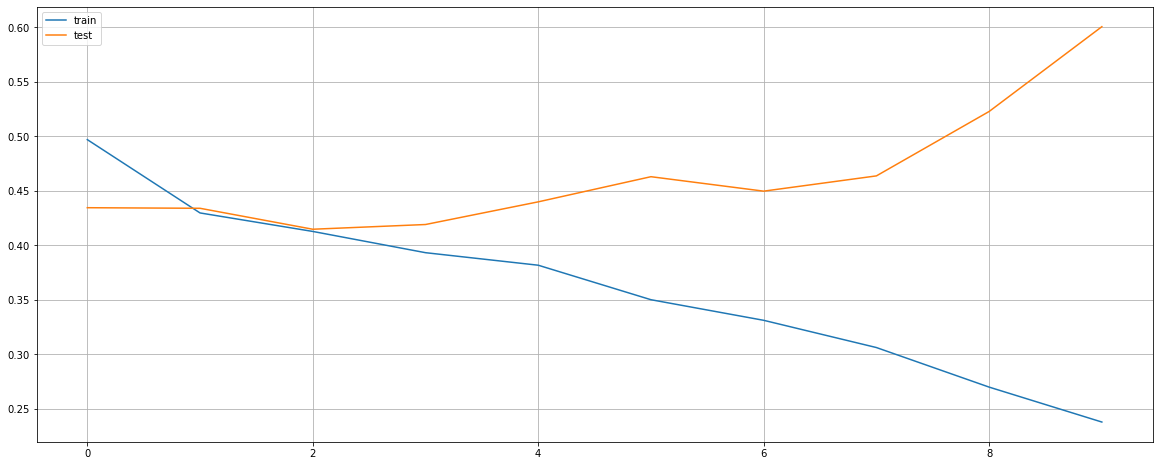

In [41]:
plt.figure(figsize=(20,8))
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()
plt.grid()
plt.show()

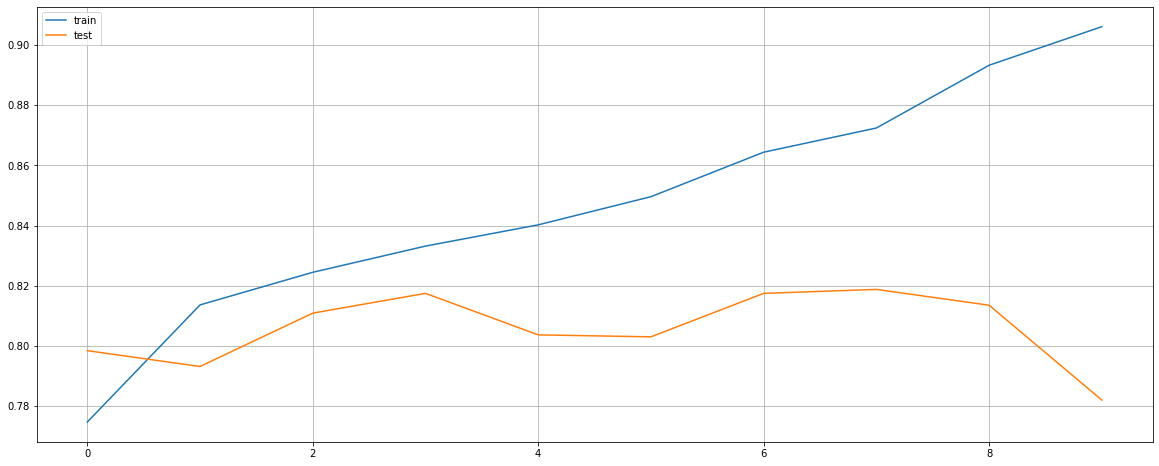

In [42]:
plt.figure(figsize=(20,8))
plt.plot(history1.history['accuracy'], label='train')
plt.plot(history1.history['val_accuracy'], label='test')
plt.legend()
plt.grid()
plt.show()

In [43]:
submit = pd.DataFrame(test['id'],columns=['id'])
predictions = model1.predict(test_pad)
submit['target_prob'] = predictions
submit.head()

,id,target_prob
0,0,0.602112
1,2,0.988919
2,3,0.997898
3,9,0.743240
4,11,0.999239


In [44]:
target = [None]*len(submit)
for i in range(len(submit)):
    target[i] = np.round(submit['target_prob'][i]).astype(int)
submit['target'] = target
submit.head()

,id,target_prob,target
0,0,0.602112,1
1,2,0.988919,1
2,3,0.997898,1
3,9,0.743240,1
4,11,0.999239,1


In [45]:
submit = submit.drop('target_prob',axis=1)
submit.to_csv('real-nlp_lstm.csv',index=False)

### BERT

In [46]:
train = pd.read_csv(r'/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv(r'/kaggle/input/nlp-getting-started/test.csv')

In [47]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [48]:
Y = train['target']
train = train.drop('target',axis=1)
text_data_train = train['text']
text_data_test = test['text']

In [49]:
Y.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [50]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)
bert_model = transformers.TFBertModel.from_pretrained('bert-large-uncased')

In [51]:
def bert_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
        
          data[i],
          add_special_tokens=True,
          max_length=maximum_length,
          pad_to_max_length=True,
        
          return_attention_mask=True,
        
        )
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [52]:
train_input_ids,train_attention_masks = bert_encode(text_data_train,100)
test_input_ids,test_attention_masks = bert_encode(text_data_test,100)

In [53]:
train_input_ids[1]

array([  101,  3224,  2543,  2379,  2474,  6902,  3351, 21871,  2243,
        1012,  2710,   102,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [54]:
train_attention_masks[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [55]:
def create_model(bert_model):
    input_ids = tf.keras.Input(shape=(100,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(100,),dtype='int32')
  
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [56]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 100, 1024),  335141888   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            1025        tf_bert_model[0][1]          

In [57]:
history = model.fit([train_input_ids,train_attention_masks],Y,
                    validation_split=0.2,
                    epochs=3,
                    batch_size=5)

Epoch 1/3
1218/1218 [==============================] - 317s 260ms/step - loss: 0.4459 - accuracy: 0.8057 - val_loss: 0.3776 - val_accuracy: 0.8418
Epoch 2/3
1218/1218 [==============================] - 311s 255ms/step - loss: 0.3425 - accuracy: 0.8678 - val_loss: 0.4771 - val_accuracy: 0.7919
Epoch 3/3
1218/1218 [==============================] - 311s 255ms/step - loss: 0.2771 - accuracy: 0.8936 - val_loss: 0.3920 - val_accuracy: 0.8418


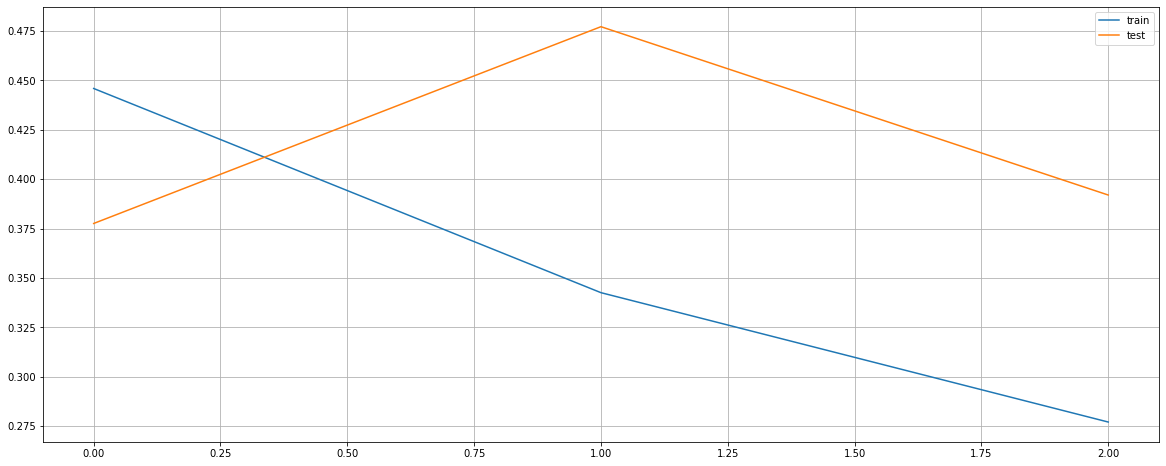

In [58]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid()
plt.show()

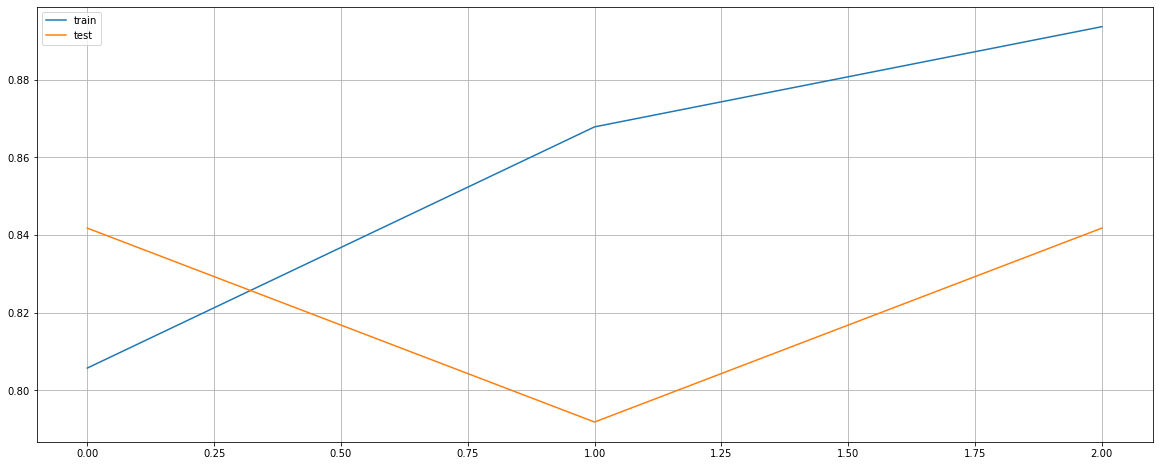

In [59]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.grid()
plt.show()

In [60]:
result = model.predict([test_input_ids,test_attention_masks])
result = np.round(result).astype(int)
submit = pd.DataFrame(test['id'],columns=['id'])
submit['target'] = result
submit.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [61]:
submit.to_csv('real_nlp_bert.csv',index=False)

Due to shortage of computing power, it is hard to get good result, even if I used modern methodology like BERT.
I think my result could be better If I have much computing power.